# Text Vectorization Techniques

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import requests
import json
import pandas as pd
from pprint import pprint
import os
import glob
import re
import string
from nltk.corpus import stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Sample sports commentary from different sports
commentaries = [
    "Messi dribbles past the defender, cuts inside and shoots! GOAL! Incredible finish from the Argentine!",
    "Federer with an amazing backhand down the line! His opponent had no chance to return that.",
    "Hamilton takes the inside line into turn 3, overtaking Verstappen with a brilliant move!",
    "Curry for three... BANG! Nothing but net from downtown. The crowd goes wild!",
    "Touchdown! Brady finds Gronkowski in the end zone with a perfect pass!"
]

sports = ["soccer", "tennis", "formula1", "basketball", "football"]

In [ ]:
# Bag of Words representation
print("Bag of Words Representation:")
count_vectorizer = CountVectorizer()
bow_matrix = count_vectorizer.fit_transform(commentaries)
bow_df = pd.DataFrame(
    bow_matrix.toarray(),
    columns=count_vectorizer.get_feature_names_out(),
    index=sports
)
print(f"Shape: {bow_matrix.shape}")
print(bow_df.iloc[:, :10])  # Show first 10 features

Bag of Words Representation:
Shape: (5, 57)
            amazing  an  and  argentine  backhand  bang  brady  brilliant  \
soccer            0   0    1          1         0     0      0          0   
tennis            1   1    0          0         1     0      0          0   
formula1          0   0    0          0         0     0      0          1   
basketball        0   0    0          0         0     1      0          0   
football          0   0    0          0         0     0      1          0   

            but  chance  
soccer        0       0  
tennis        0       1  
formula1      0       0  
basketball    1       0  
football      0       0  


In [ ]:
# TF-IDF Representation
print("\nTF-IDF Representation:")
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(commentaries)
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=sports
)
print(f"Shape: {tfidf_matrix.shape}")
print(tfidf_df.iloc[:, :10])  # Show first 10 features


TF-IDF Representation:
Shape: (5, 57)
             amazing        an       and  argentine  backhand      bang  \
soccer      0.000000  0.000000  0.275136   0.275136  0.000000  0.000000   
tennis      0.264198  0.264198  0.000000   0.000000  0.264198  0.000000   
formula1    0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   
basketball  0.000000  0.000000  0.000000   0.000000  0.000000  0.290154   
football    0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   

               brady  brilliant       but    chance  
soccer      0.000000   0.000000  0.000000  0.000000  
tennis      0.000000   0.000000  0.000000  0.264198  
formula1    0.000000   0.316586  0.000000  0.000000  
basketball  0.000000   0.000000  0.290154  0.000000  
football    0.321486   0.000000  0.000000  0.000000  


## Top 10 tfidf

In [ ]:
# Load data
df = pd.read_csv('/content/test (1).csv', encoding='cp1252')

In [ ]:
# Keep only relevant columns and rename
df = df[['text', 'sentiment']].rename(columns={'text': 'tweet_cleaned', 'sentiment': 'Labels'})

In [ ]:
# Compile regex to remove all ASCII punctuation + '।' character
punct_pattern = re.compile(f"[{re.escape(string.punctuation)}।]")

In [ ]:
# Load English stopwords once
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_and_tokenize(text):
    if not isinstance(text, str):
        return []

    # Remove all punctuation
    text = punct_pattern.sub('', text)

    # Remove newlines, tabs, and extra spaces
    text = text.replace('\n', ' ').replace('\t', ' ').strip()
    text = re.sub(r'\s+', ' ', text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove possessive 's
    text = text.replace("'s", "")

    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word.lower() not in stop_words]

    return tokens

In [ ]:
# Apply cleaning and tokenization
df['tweet_cleaned'] = df['tweet_cleaned'].apply(clean_and_tokenize)

In [ ]:
# Drop rows where token list is empty after cleaning
df = df[df['tweet_cleaned'].map(len) > 0].reset_index(drop=True)

In [ ]:
# Prepare tokenized sentences for TF-IDF
all_tokenized_list_of_sentences = df['tweet_cleaned'].tolist()

In [ ]:
# Identity tokenizer for pre-tokenized input
def identity_tokenizer(text):
    return text

In [ ]:
# TF-IDF vectorizer using pre-tokenized input
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, max_features=10)

In [ ]:
# Fit-transform the tokenized data
tfidf_matrix = tfidf.fit_transform(all_tokenized_list_of_sentences)

# Compute average TF-IDF weights per term
weights = np.asarray(tfidf_matrix.mean(axis=0)).ravel()

In [ ]:
# Create DataFrame of terms and weights sorted descending
weights_df = pd.DataFrame({
    'term': tfidf.get_feature_names_out(),
    'weight': weights
}).sort_values(by='weight', ascending=False).reset_index(drop=True)

In [ ]:
# Show results
print(weights_df)

   term    weight
0    Im  0.057274
1   day  0.042599
2   get  0.038563
3  like  0.038402
4  good  0.038389
5    go  0.035614
6   got  0.034848
7    im  0.032718
8  know  0.029523
9  dont  0.028860


## N-grams

In [ ]:
# N-grams example
print("\nUsing N-grams (1-2):")
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2))
ngram_matrix = ngram_vectorizer.fit_transform(commentaries)
print(f"Shape with n-grams: {ngram_matrix.shape}")
ngram_features = ngram_vectorizer.get_feature_names_out()
print("Sample n-gram features:")
print(sorted([f for f in ngram_features if ' ' in f])[:10])  # Show some bigrams


Using N-grams (1-2):
Shape with n-grams: (5, 119)
Sample n-gram features:
['amazing backhand', 'an amazing', 'and shoots', 'backhand down', 'bang nothing', 'brady finds', 'brilliant move', 'but net', 'chance to', 'crowd goes']


# Word Embeddings with Gensim

In [ ]:
!pip install numpy==1.26.4
# !pip install --force-reinstall --no-cache-dir gensim

In [ ]:
!pip install gensim

In [ ]:
!pip install --upgrade gensim numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install gensim==4.3.0 numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pyfume to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.1 MB/s eta 0:00:00
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3506 sha256=a590b00c31343e9fb1db48abd0334678db7cc066759003adb675e0117f3e50cc
  Stored in directory: /root/.cache/pip/wheels/9d/ff/2f/afe4cd56f47de147407705626517d68bea0f3b74eb1fb168e6
Successfully built miniful
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.3
    Uninstalling gensim-4.3.3:
      Successfully uninstalled gensim-4.3.3


In [ ]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.4 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have nu

In [ ]:
!pip uninstall gensim
!pip install gensim

Found existing installation: gensim 4.3.0
Uninstalling gensim-4.3.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/gensim-4.3.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/gensim/*
Proceed (Y/n)? y
  Successfully uninstalled gensim-4.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 35.3 MB/s eta 0:00:00


In [ ]:
import numpy
import gensim

print("NumPy version:", numpy.__version__)
print("Gensim version:", gensim.__version__)

NumPy version: 1.23.5
Gensim version: 4.3.3


In [ ]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Prepare corpus for Word2Vec (tokenized sentences)
from nltk.tokenize import word_tokenize
import re

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
# Sample sports commentary from different sports

commentaries = [
    "Messi scores a stunning goal in the final match of the tournament",
    "The government announced new policies on cybersecurity",
    "NASA plans to send astronauts to Mars by 2035",
    "The prime minister visited the flood-affected regions",
    "Federer wins his 21st Grand Slam title with a superb performance",
    "Apple releases a new iPhone with AI-powered features",
    "The opposition demands a parliamentary debate on economic reforms",
    "Curry hits a three-pointer at the buzzer to win the game",
    "Google develops an advanced quantum computing chip",
    "Hamilton wins the Grand Prix after a thrilling race"
]

sports = ["soccer", "tennis", "formula1", "basketball", "football"]

In [ ]:
# Using a larger corpus for better embedding quality
# In a real scenario, we would use thousands of sentences
sports_corpus = commentaries + [
    "The striker shoots from outside the box but hits the crossbar.",
    "The point guard drives to the basket and makes a perfect assist.",
    "The quarterback throws a long pass downfield to the wide receiver.",
    "The driver sets the fastest lap time in the final sector.",
    "The server delivers an ace to win the second set.",
    # Additional sentences would be loaded from dataset
]

tokenized_corpus = [word_tokenize(preprocess(sentence)) for sentence in sports_corpus]

In [ ]:
tokenized_corpus

[['messi',
  'scores',
  'a',
  'stunning',
  'goal',
  'in',
  'the',
  'final',
  'match',
  'of',
  'the',
  'tournament'],
 ['the', 'government', 'announced', 'new', 'policies', 'on', 'cybersecurity'],
 ['nasa', 'plans', 'to', 'send', 'astronauts', 'to', 'mars', 'by', '2035'],
 ['the', 'prime', 'minister', 'visited', 'the', 'floodaffected', 'regions'],
 ['federer',
  'wins',
  'his',
  '21st',
  'grand',
  'slam',
  'title',
  'with',
  'a',
  'superb',
  'performance'],
 ['apple', 'releases', 'a', 'new', 'iphone', 'with', 'aipowered', 'features'],
 ['the',
  'opposition',
  'demands',
  'a',
  'parliamentary',
  'debate',
  'on',
  'economic',
  'reforms'],
 ['curry',
  'hits',
  'a',
  'threepointer',
  'at',
  'the',
  'buzzer',
  'to',
  'win',
  'the',
  'game'],
 ['google', 'develops', 'an', 'advanced', 'quantum', 'computing', 'chip'],
 ['hamilton',
  'wins',
  'the',
  'grand',
  'prix',
  'after',
  'a',
  'thrilling',
  'race'],
 ['the',
  'striker',
  'shoots',
  'from',


In [ ]:
# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# Extract and visualize embeddings
def plot_embeddings(model, words):
    # Extract word vectors
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    words = [word for word in words if word in model.wv]

    if not word_vectors:
        print("None of the specified words found in vocabulary.")
        return

    # Reduce dimensions for visualization
    pca = PCA(n_components=4)
    result = pca.fit_transform(word_vectors)

    # Create plot
    plt.figure(figsize=(10, 8))
    plt.scatter(result[:, 0], result[:, 1], c='lightblue')

    # Add labels
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.title("Word Embeddings Visualization")
    plt.grid(True)
    plt.show()

sentences=tokenized_corpus: Your input data (already tokenized list of word lists).

vector_size=100: Each word will be represented as a 100-dimensional vector.

window=5: The model looks at 5 words to the left and right of each word to understand its context.

min_count=1: Even words that appear only once in the dataset are included.

workers=4: Uses 4 CPU cores to train faster.

Reduces 100-dimensional word vectors to 4 dimensions using Principal Component Analysis (PCA).

.fit_transform(word_vectors) does two things:

**Fit:**

Learns how to rotate, shift, and scale the original 100-dimensional vectors so they can be represented in 4 dimensions while preserving as much variance (information) as possible.

**Transform:**

Applies this learned transformation to your word vectors, reducing them from 100 dimensions to 4 dimensions.

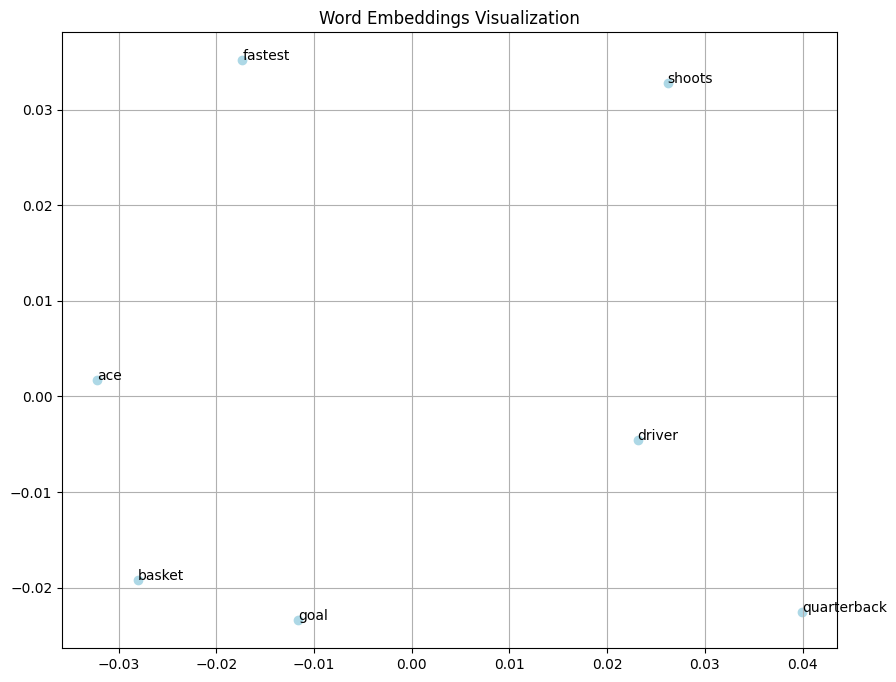


Words similar to 'goal':
announced: 0.2598
send: 0.2241
debate: 0.1783
hamilton: 0.1460
visited: 0.1459


In [ ]:
# Visualize sport-specific terms
sports_terms = [
    "goal", "dribbles", "shoots", "basket", "touchdown",
    "quarterback", "ace", "driver", "fastest", "defender"
]

plot_embeddings(w2v_model, sports_terms)

# Find similar words for a sports term
print("\nWords similar to 'goal':")
try:
    similar_words = w2v_model.wv.most_similar("goal", topn=5)
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")
except KeyError:
    print("Word 'goal' not in vocabulary. Try with a larger corpus.")

In [ ]:
# Check embedding dimension for the word 'goal'
word = 'goal'
if word in w2v_model.wv:
    print(f"Dimension of word embedding for '{word}': {w2v_model.wv[word].shape}")
else:
    print(f"Word '{word}' not found in vocabulary.")

Dimension of word embedding for 'goal': (100,)


In [ ]:
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings

warnings.filterwarnings(action='ignore')

s = [
    "Messi dribbles past the defender, cuts inside and shoots! GOAL! Incredible finish from the Argentine!",
    "Federer with an amazing backhand down the line! His opponent had no chance to return that.",
    "Hamilton takes the inside line into turn 3, overtaking Verstappen with a brilliant move!",
    "Curry for three... BANG! Nothing but net from downtown. The crowd goes wild!",
    "Touchdown! Brady finds Gronkowski in the end zone with a perfect pass!"
]

# Replace \n with space in each sentence
f = [sentence.replace("\n", " ") for sentence in s]

# Join list into a single string
text = " ".join(f)

data = []

# iterate through each sentence
for i in sent_tokenize(text):
    temp = []

    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())

    data.append(temp)

# Create CBOW model
model1 = gensim.models.Word2Vec(data, min_count=1, vector_size=100, window=5)

# Print vocabulary to check what words are available
print("Vocabulary:", list(model1.wv.index_to_key))

# Print results only if words exist
if 'messi' in model1.wv and 'brilliant' in model1.wv:
    print("Cosine similarity between 'messi' and 'brilliant' - CBOW : ",
          model1.wv.similarity('messi', 'brilliant'))

# Create Skip Gram model
model2 = gensim.models.Word2Vec(data, min_count=1, vector_size=100, window=5, sg=1)

if 'messi' in model2.wv and 'brilliant' in model2.wv:
    print("Cosine similarity between 'messi' and 'brilliant' - Skip Gram : ",
          model2.wv.similarity('messi', 'brilliant'))

Vocabulary: ['!', 'the', 'with', 'inside', 'from', 'a', 'line', '.', ',', 'had', 'an', 'his', 'no', 'chance', 'down', 'to', 'backhand', 'amazing', 'opponent', 'argentine', 'federer', 'that', 'finish', 'incredible', 'goal', 'shoots', 'and', 'cuts', 'defender', 'past', 'dribbles', 'return', 'pass', 'perfect', 'hamilton', 'zone', 'end', 'in', 'gronkowski', 'finds', 'brady', 'touchdown', 'wild', 'goes', 'crowd', 'downtown', 'net', 'but', 'nothing', 'bang', '...', 'three', 'for', 'curry', 'move', 'brilliant', 'verstappen', 'overtaking', '3', 'turn', 'into', 'takes', 'messi']
Cosine similarity between 'messi' and 'brilliant' - CBOW :  0.045464005
Cosine similarity between 'messi' and 'brilliant' - Skip Gram :  0.046776664
